In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

Num GPUs Available:  1


In [2]:
img_height = 112
img_width = 112

epoch = 5
batch_size = 64

base_dir = r'C:\Users\Szymon\CIFAR-100'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

50000
10000
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    ])

base_model = tf.keras.applications.ResNet50(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False)

base_model.trainable = False

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 112, 112, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
Total params: 23,792,612
Trainable params: 204,900
Non-trainable params: 23,587,712
_________________________________________________________________


In [4]:
train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time)

Epoch 1/5
781/781 [==============================] - 186s 225ms/step - loss: 2.5722 - accuracy: 0.3805 - val_loss: 1.6726 - val_accuracy: 0.5629
Epoch 2/5
781/781 [==============================] - 177s 227ms/step - loss: 2.0827 - accuracy: 0.4767 - val_loss: 1.6517 - val_accuracy: 0.5701
Epoch 3/5
781/781 [==============================] - 177s 227ms/step - loss: 1.9731 - accuracy: 0.5022 - val_loss: 1.6370 - val_accuracy: 0.5857
Epoch 4/5
781/781 [==============================] - 177s 227ms/step - loss: 1.9379 - accuracy: 0.5137 - val_loss: 1.5395 - val_accuracy: 0.6062
Epoch 5/5
781/781 [==============================] - 173s 222ms/step - loss: 1.8407 - accuracy: 0.5274 - val_loss: 1.7185 - val_accuracy: 0.5897
891.0082244


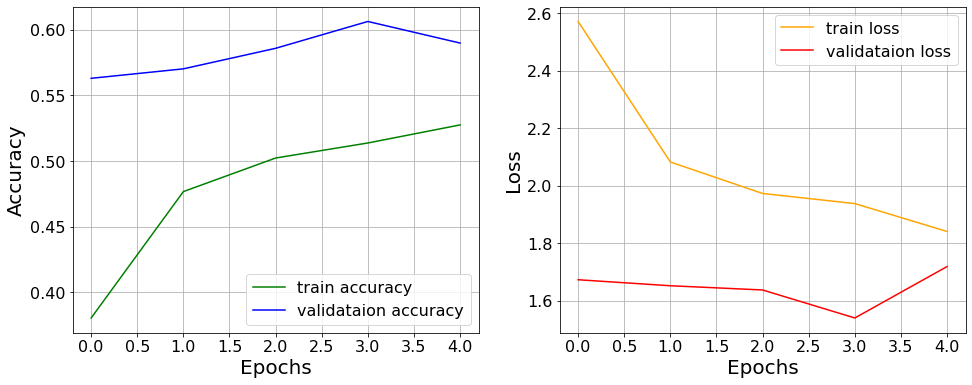

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [6]:
epoch = 25

for layer in model.layers:
    layer.trainable = True

start_time2 = time.perf_counter()
model_finetune = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time2)

Epoch 1/25
781/781 [==============================] - 176s 224ms/step - loss: 1.8206 - accuracy: 0.5373 - val_loss: 1.8186 - val_accuracy: 0.5657
Epoch 2/25
781/781 [==============================] - 175s 224ms/step - loss: 1.8276 - accuracy: 0.5383 - val_loss: 1.5938 - val_accuracy: 0.6134
Epoch 3/25
781/781 [==============================] - 176s 226ms/step - loss: 1.8710 - accuracy: 0.5312 - val_loss: 1.6797 - val_accuracy: 0.6078
Epoch 4/25
781/781 [==============================] - 176s 225ms/step - loss: 1.8558 - accuracy: 0.5366 - val_loss: 1.7983 - val_accuracy: 0.5781
Epoch 5/25
781/781 [==============================] - 177s 226ms/step - loss: 1.7865 - accuracy: 0.5455 - val_loss: 1.6642 - val_accuracy: 0.6014
Epoch 6/25
781/781 [==============================] - 178s 228ms/step - loss: 1.7948 - accuracy: 0.5480 - val_loss: 1.7553 - val_accuracy: 0.5905
Epoch 7/25
781/781 [==============================] - 176s 225ms/step - loss: 1.8298 - accuracy: 0.5446 - val_loss: 1.6986 -

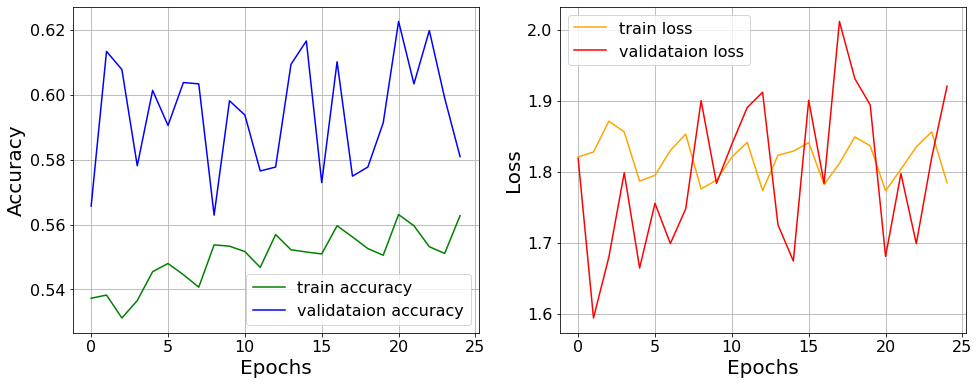

In [7]:
train_loss = model_finetune.history['loss']
train_acc = model_finetune.history['accuracy']
valid_loss = model_finetune.history['val_loss']
valid_acc = model_finetune.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results_ft.png')